In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier as GB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold

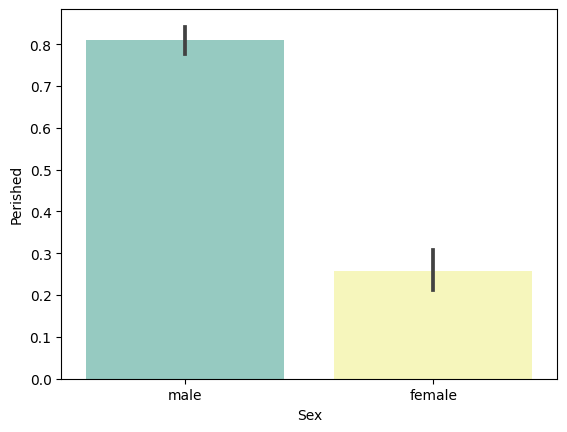

(891, 12)
(418, 12)


In [3]:
path = '/content/drive/MyDrive/GCI/分析コンペ1/data/'

train_data = pd.read_csv(path + 'train.csv')
test_data = pd.read_csv(path + 'test.csv')

# train_dataとtest_dataの連結
test_data['Perished'] = np.nan
df = pd.concat([train_data, test_data], ignore_index=True, sort=False)

sns.barplot(x='Sex', y='Perished', data=df, palette='Set3')
plt.show()
print(train_data.shape)
print(test_data.shape)

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)


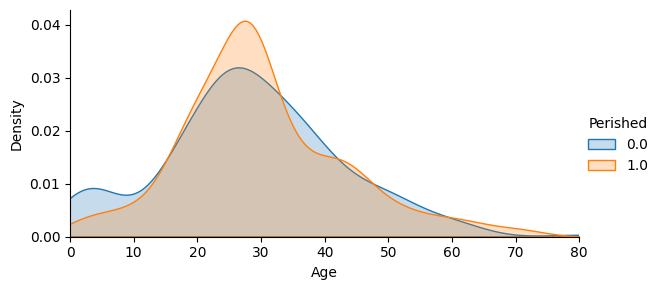

In [4]:
# 推定に使用する項目を指定
age_df = df[['Age', 'Pclass','Sex','Parch','SibSp']]

# ラベル特徴量をワンホットエンコーディング
age_df=pd.get_dummies(age_df)

# 学習データとテストデータに分離し、numpyに変換
known_age = age_df[age_df.Age.notnull()].values  
unknown_age = age_df[age_df.Age.isnull()].values

# 学習データをX, yに分離
X = known_age[:, 1:]  
y = known_age[:, 0]

# ランダムフォレストで推定モデルを構築
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)

# 推定モデルを使って、テストデータのAgeを予測し、補完
predictedAges = rfr.predict(unknown_age[:, 1::])
df.loc[(df.Age.isnull()), 'Age'] = predictedAges 

# 年齢別生存曲線と死亡曲線
facet = sns.FacetGrid(df[0:890], hue="Perished",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df.loc[0:890,'Age'].max()))
facet.add_legend()
plt.show()

<Axes: xlabel='Title', ylabel='Perished'>

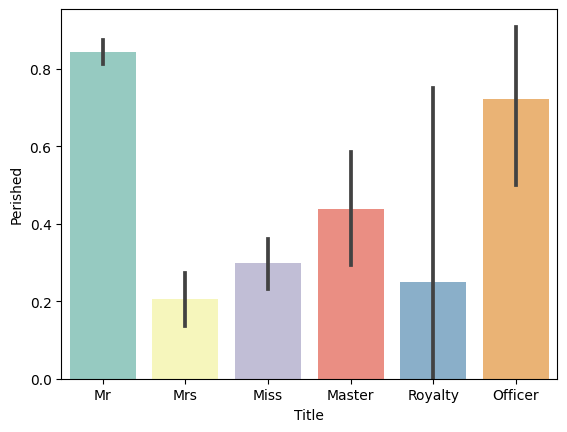

In [5]:
# Nameから敬称(Title)を抽出し、グルーピング
df['Title'] = df['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
df['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
df['Title'].replace(['Don', 'Sir',  'the Countess', 'Lady', 'Dona'], 'Royalty', inplace=True)
df['Title'].replace(['Mme', 'Ms'], 'Mrs', inplace=True)
df['Title'].replace(['Mlle'], 'Miss', inplace=True)
df['Title'].replace(['Jonkheer'], 'Master', inplace=True)
sns.barplot(x='Title', y='Perished', data=df, palette='Set3')

In [6]:
df['Surname'] = df['Name'].map(lambda name:name.split(',')[0].strip())

# 同じSurname(苗字)の出現頻度をカウント(出現回数が2以上なら家族)
df['FamilyGroup'] = df['Surname'].map(df['Surname'].value_counts()) 

In [7]:
Female_Child_Group=df.loc[(df['FamilyGroup']>=2) & ((df['Age']<=16) | (df['Sex']=='female'))]
Female_Child_Group=Female_Child_Group.groupby('Surname')['Perished'].mean()
print(Female_Child_Group.value_counts())

0.000000    113
1.000000     32
0.250000      2
0.500000      1
0.666667      1
0.857143      1
Name: Perished, dtype: int64


In [8]:
# 家族で16才超えかつ男性の生存率
Male_Adult_Group=df.loc[(df['FamilyGroup']>=2) & (df['Age']>16) & (df['Sex']=='male')]
Male_Adult_List=Male_Adult_Group.groupby('Surname')['Perished'].mean()
print(Male_Adult_List.value_counts())

1.000000    115
0.000000     21
0.500000      6
0.666667      2
0.750000      1
Name: Perished, dtype: int64


In [9]:
# デッドリストとサバイブリストの作成
Survived_list=set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)
Dead_list=set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==1)].index)

# デッドリストとサバイブリストの表示
print('Dead_list = ', Dead_list)
print('Survived_list = ', Survived_list)

# デッドリストとサバイブリストをSex, Age, Title に反映させる
df.loc[(df['Perished'].isnull()) & (df['Perished'].apply(lambda x:x in Dead_list)),\
             ['Sex','Age','Title']] = ['male',28.0,'Mr']
df.loc[(df['Perished'].isnull()) & (df['Perished'].apply(lambda x:x in Survived_list)),\
             ['Sex','Age','Title']] = ['female',5.0,'Mrs']

Dead_list =  {'Douglas', 'Carlsson', 'Cor', 'Newell', 'Ali', 'Van Impe', 'Bourke', 'Chaffee', 'Cacic', 'Ryan', 'Crosby', 'Thorneycroft', 'Abelson', 'Holverson', 'Lobb', 'Wiklund', 'Bryhl', 'Johnson', 'Kantor', 'Jacobsohn', 'Klasen', 'Petroff', 'Widener', 'Arnold-Franchi', 'Davies', 'Braund', 'Ostby', 'Cribb', 'Minahan', 'Baxter', 'Davidson', 'Rogers', 'Carrau', "O'Brien", 'Dennis', 'Nasser', 'Elias', 'Morley', 'Gustafsson', 'Chapman', 'Penasco y Castellana', 'Turpin', 'Allen', 'Keane', 'McNamee', 'Smith', 'Rosblom', 'Lennon', 'Graham', 'Hansen', 'Andrews', 'Laroche', 'Backstrom', 'Danbom', 'Bowen', 'Pears', 'Boulos', 'Meyer', 'Wright', 'Goldsmith', 'West', 'Hocking', 'Yasbeck', 'White', 'del Carlo', 'Gale', 'McCarthy', 'van Billiard', 'Dean', 'Hart', 'Calic', 'Kink', 'Olsen', 'Samaan', 'Taussig', 'Karlsson', 'Cook', 'Giles', 'Fox', 'Attalah', 'Webber', 'Risien', 'Moran', 'Lindell', 'Betros', 'Fortune', 'Oreskovic', 'Collyer', 'Larsson', 'Silvey', 'Jensen', 'Coleff', 'Moore', 'Navratil'

In [10]:
# 欠損値を Embarked='S', Pclass=3 の平均値で補完
fare=df.loc[(df['Embarked'] == 'S') & (df['Pclass'] == 3), 'Fare'].median()
df['Fare']=df['Fare'].fillna(fare)

In [11]:
# Family = SibSp + Parch + 1 を特徴量とし、グルーピング
df['Family']=df['SibSp']+df['Parch']+1
df.loc[(df['Family']>=2) & (df['Family']<=4), 'Family_label'] = 2
df.loc[(df['Family']>=5) & (df['Family']<=7) | (df['Family']==1), 'Family_label'] = 1  # == に注意
df.loc[(df['Family']>=8), 'Family_label'] = 0

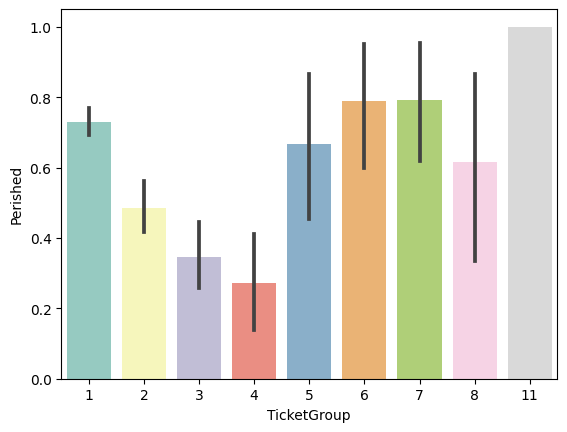

In [12]:
# 同一Ticketナンバーの人が何人いるかを特徴量として抽出
Ticket_Count = dict(df['Ticket'].value_counts())
df['TicketGroup'] = df['Ticket'].map(Ticket_Count)
sns.barplot(x='TicketGroup', y='Perished', data=df, palette='Set3')
plt.show()

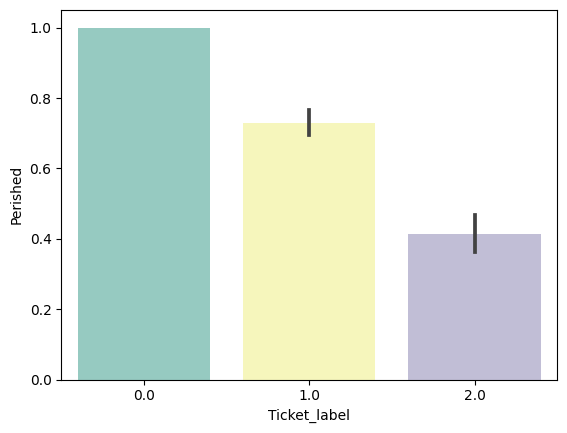

In [13]:
# 生存率で3つにグルーピング
df.loc[(df['TicketGroup']>=2) & (df['TicketGroup']<=4), 'Ticket_label'] = 2
df.loc[(df['TicketGroup']>=5) & (df['TicketGroup']<=8) | (df['TicketGroup']==1), 'Ticket_label'] = 1  
df.loc[(df['TicketGroup']>=11), 'Ticket_label'] = 0
sns.barplot(x='Ticket_label', y='Perished', data=df, palette='Set3')
plt.show()

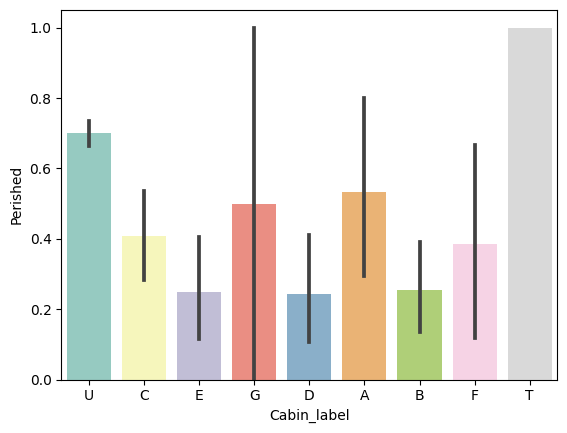

In [14]:
# Cabinの先頭文字を特徴量とする(欠損値は U )
df['Cabin'] = df['Cabin'].fillna('Unknown')
df['Cabin_label']=df['Cabin'].str.get(0)
sns.barplot(x='Cabin_label', y='Perished', data=df, palette='Set3')
plt.show()

In [15]:
# 欠損値をSで補完
df['Embarked'] = df['Embarked'].fillna('S') 

In [16]:
# 推定に使用する項目を指定
df1 = df[['Perished','Pclass','Sex','Age','Fare','Embarked','Title','Family_label','Cabin_label','Ticket_label']]

# ラベル特徴量をワンホットエンコーディング
df2 = pd.get_dummies(df1)

# データセットを trainとtestに分割
train = df2[df2['Perished'].notnull()]
test = df2[df2['Perished'].isnull()].drop('Perished',axis=1)

# データフレームをnumpyに変換
X = train.values[:,1:]  
y = train.values[:,0] 
test_x = test.values


In [17]:
# 採用する特徴量を25個から20個に絞り込む
select = SelectKBest(k = 20)
selected_x = select.fit_transform(X, y)


#ランダムフォレスト
clf = RandomForestClassifier(random_state = 10, 
                             warm_start = True,  # 既にフィットしたモデルに学習を追加 
                             n_estimators = 26,
                             max_depth = 6, 
                             max_features = 'sqrt')
pipe1 = make_pipeline(select, StandardScaler(), clf)

#SVM
svc = LinearSVC(C=0.01, max_iter=100, penalty='l2')
pipe2 = make_pipeline(select, StandardScaler(), svc)

#GBDT
gb = GB(random_state = 10, learning_rate=0.1, max_depth=5, n_estimators=200)
pipe3 = make_pipeline(select, StandardScaler(), gb)

#ロジスティック回帰
lr = LogisticRegression(random_state=42, max_iter=1000, C=0.1, penalty='l2', solver='liblinear')
pipe4 = make_pipeline(select, StandardScaler(), lr)


#XGBoost
xgb = xgb.XGBClassifier(colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=0, subsample=0.8)
pipe5 = make_pipeline(select, StandardScaler(), xgb)

In [18]:
# 投票アンサンブルのモデルを作成
ensemble_model = VotingClassifier(
    estimators=[('rm', pipe1), ('gbdt', pipe3), ('lr', pipe4), ('xgb', pipe5)],
    voting='soft' , # 'hard'で多数決（クラスラベルのみ）を使用
    weights=[3, 1, 1, 3]
)

pipeline_ensemble = make_pipeline(
    ensemble_model
)

pipeline_ensemble.fit(X, y)
pred = pipeline_ensemble.predict(test_x)

pred.shape

# X_train, X_test, y_train, y_test = train_test_split(selected_x, y, random_state=0)
# ensemble_model.fit(X_train, y_train)

# selected_test = select.fit_transform(X_test, y_test)
# pred = ensemble_model.predict(test_x)
# pred.shape

# submit = df[['PassengerId']]
# submit['Perished'] = pred
# submit.head()
# ('svm', svc),

#y_pred = cross_val_predict(ensemble_model, selected_x, y, cv=10)
# 交差検証を実行
#cv_results = cross_validate(ensemble_model, selected_x, y, cv=10, scoring='accuracy')

# 各評価指標の平均値を取得
# mean_score = cv_results['test_score'].mean()
# mean_std = cv_results['test_score'].std()

# 結果の出力
# print('Mean Score: ', mean_score)
# print('Mean Standard Deviation: ', mean_std)
#y_pred.shape


(418,)

In [19]:
# # 交差検証の分割数を指定
# n_splits = 10

# # 交差検証の分割を定義
# kfold = KFold(n_splits=n_splits)

# # 予測結果を格納するリストを作成
# y_pred_list = []

# # 交差検証を実行
# for train_index, test_index in kfold.split(selected_x):
#     # 学習データとテストデータを取得
#     X_train, X_test = selected_x[train_index], selected_x[test_index]
#     y_train, y_test = y[train_index], y[test_index]
    
#     # モデルの学習
#     ensemble_model.fit(X_train, y_train)
    
#     # テストデータの予測
#     y_pred = ensemble_model.predict(test_x)
    
#     # 予測結果をリストに追加
#     y_pred_list.append(y_pred)

# # 予測結果を結合して最終的な予測結果を作成
# y_pred = np.concatenate(y_pred_list)
# y_pred.shape

In [20]:
PassengerId = test_data['PassengerId']
submission = pd.DataFrame({"PassengerId": PassengerId, "Perished": pred.astype(np.int32)})

submission.to_csv("/content/drive/MyDrive/GCI/分析コンペ1/out_csv/submit7.csv", index=False)
submission.shape

(418, 2)